## Creating search engine for book title ##

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sklearn
# import pickleshare as ps

In [3]:
# df created in notebooks Bias_authors_countries and Genre_susanne 
clean_names_genre = pd.read_csv('data/clean_names_genre.csv')
clean_names_genre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183600 entries, 0 to 183599
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 183600 non-null  object 
 1   book_title           183600 non-null  object 
 2   book_author          183600 non-null  object 
 3   year_of_publication  183600 non-null  object 
 4   publisher            183600 non-null  object 
 5   genre                183600 non-null  object 
 6   user_id              183600 non-null  float64
 7   book_rating          183600 non-null  float64
 8   location             183600 non-null  object 
 9   age                  183600 non-null  object 
 10  age_numeric          137577 non-null  float64
 11  age_bins             183600 non-null  object 
 12  mod_book_author      183600 non-null  object 
 13  mod_book_title       183600 non-null  object 
 14  mod_publisher        183600 non-null  object 
 15  country          

In [4]:
clean_names_genre['user_id'] = clean_names_genre['user_id'].astype(int)
clean_names_genre['book_rating'] = clean_names_genre['book_rating'].astype(int)

### 1. Search engine - book title ###

#### pre-processing data ####

In [7]:
# dropping columns that are not needed

data_kept = clean_names_genre.drop(['book_title', 'book_author', 'genre', 'location', 'age', 'age_numeric', 'age_bins', 'country', 'name_surname', 'surname'], axis=1)


In [8]:
data_kept.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183600 entries, 0 to 183599
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 183600 non-null  object
 1   year_of_publication  183600 non-null  object
 2   publisher            183600 non-null  object
 3   user_id              183600 non-null  int64 
 4   book_rating          183600 non-null  int64 
 5   mod_book_author      183600 non-null  object
 6   mod_book_title       183600 non-null  object
 7   mod_publisher        183600 non-null  object
 8   categorized_genre    183600 non-null  object
dtypes: int64(2), object(7)
memory usage: 12.6+ MB


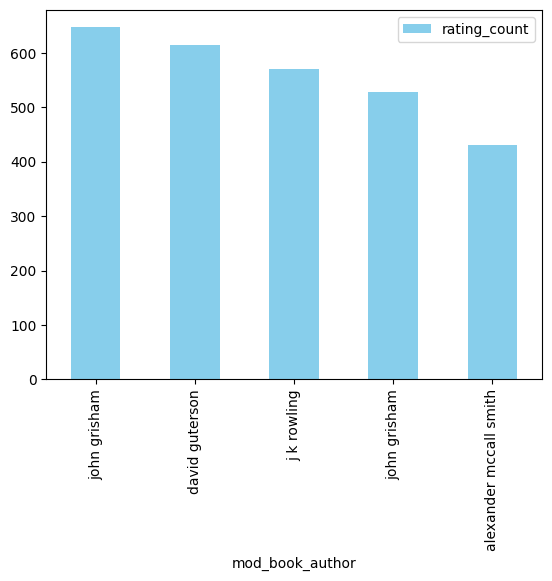

In [10]:
# calculate the rating count for each book and the average rating for each book
# 1. Group by 'isbn' and count the number of ratings for each ISBN
isbn_rating_counts = data_kept.groupby(['mod_book_title', 'mod_book_author', 'isbn']).size().reset_index(name='rating_count')

# Display the DataFrame to verify the result
ratings = isbn_rating_counts.sort_values('rating_count', ascending=False).head().plot(kind='bar', x='mod_book_author', y='rating_count', color='skyblue')

In [11]:
# 2. Calculate the average rating for each book

to_be_rated = data_kept[['isbn', 'book_rating']]
averageRating = to_be_rated.groupby('isbn')['book_rating'].mean().round(1).reset_index()
averageRating.rename(columns={'book_rating': 'average_rating'}, inplace=True)
average_rating = averageRating[['isbn','average_rating']]

# Merge the average ratings back with the original dataset
averageRatingdf = pd.merge(isbn_rating_counts, average_rating, on='isbn', how='left')

# Remove duplicate entries
#averageRatingdf = averageRatingdf[['isbn', 'average_rating']].drop_duplicates(subset=['isbn'])

averageRatingdf.head() 

,mod_book_title,mod_book_author,isbn,rating_count,average_rating
0,0815 heute,kirst,3442013453,1,7.0
1,1 2 3,tana hoban,068802579X,3,5.3
2,10 000 dreams interpreted,gustavus hindman miller,1862044082,1,0.0
3,100 chocolate,katherine khodorowsky,1577173074,1,0.0
4,1000 years 1000 people ranking the men and wom...,agnes hooper gottlieb,1568362536,4,6.8


In [12]:
averageRatingdf["mod_book_title"] = averageRatingdf['mod_book_title'].str.replace("[^a-zA-Z0-9]", " ", regex=True)    #removing special characters from book titles   
averageRatingdf.head()

,mod_book_title,mod_book_author,isbn,rating_count,average_rating
0,0815 heute,kirst,3442013453,1,7.0
1,1 2 3,tana hoban,068802579X,3,5.3
2,10 000 dreams interpreted,gustavus hindman miller,1862044082,1,0.0
3,100 chocolate,katherine khodorowsky,1577173074,1,0.0
4,1000 years 1000 people ranking the men and wom...,agnes hooper gottlieb,1568362536,4,6.8


In [13]:
averageRatingdf['mod_book_title'] = averageRatingdf['mod_book_title'].str.replace('\s+', ' ', regex=True)    #removing extra spaces from book titles

In [14]:
averageRatingdf = averageRatingdf[averageRatingdf['mod_book_title'].str.len() > 0]    #removing rows with empty book titles

<Axes: ylabel='rating_count'>

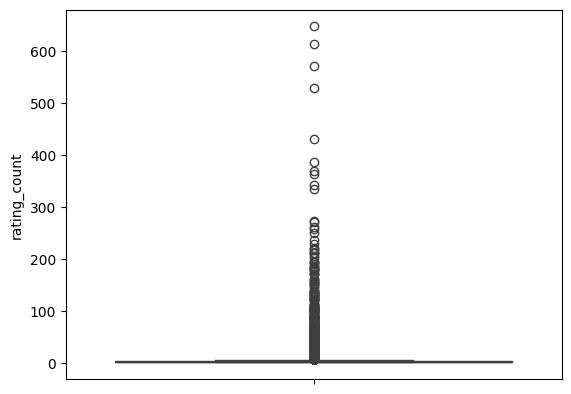

In [15]:
sns.boxplot(averageRatingdf.rating_count)

In [16]:
averageRatingdf['mod_book_title'].nunique()

57107

In [17]:
ratings = averageRatingdf[averageRatingdf['rating_count'] >= 15]    #filtering out books with less than 15 ratings
ratings.shape

(1488, 5)

### creating the search engine ###

#### Building a Term Frequency and then a Inverse Document Frequency matrix ####

In [18]:
# turning titles into TD-IDF matrix => Term Frequency-Inverse Document Frequency
from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer takes a list of strings as input and turns it into a fd-idf matrix
vectorizer = TfidfVectorizer()

tdidf = vectorizer.fit_transform(ratings['mod_book_title'])

In [19]:
# to do comparison between books, we need to calculate the cosine similarity between the books

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import re


# query function:

def search(query, vectorizer):
# setting up a search query

    #query = 'The Hobbit'
# preparing the string in the same way as the mod titles above
    processed = re.sub('[^a-zA-Z0-9]', ' ', query.lower())

# we need to turn the query into a vector using the vectorizer

    query_vector = vectorizer.transform([processed])

# to find the similarities we calculate the cosine similarity between the query vector and the tdidf matrix
    similarity = cosine_similarity(query_vector, tdidf).flatten() # flatten is used to turn the matrix into a 1D array

# to find the indices of the 10 largest similarities

    indices = np.argpartition(similarity, -10)[-10:]

# use indices to index the titles

    results = ratings.iloc[indices]   

# as there are many books with the title "The Hobbit", we only want those with the highest number of ratings

    results = results.sort_values(by='rating_count', ascending=False)

    return results.head(10)


In [20]:
search('the hitchhikers guide to the galaxy', vectorizer)

,mod_book_title,mod_book_author,isbn,rating_count,average_rating
48930,the girls guide to hunting and fishing,melissa bank,067088300X,157,3.3
48749,the four agreements a practical guide to perso...,don miguel ruiz,1878424319,133,3.5
47883,the dance of anger a womans guide to changing ...,harriet lerner,006091565X,52,2.3
51504,the power of now a guide to spiritual enlighte...,eckhart tolle,1577311523,24,3.5
52130,the salmon of doubt hitchhiking the galaxy one...,douglas adams,1400045088,21,3.6
50540,the mastery of love a practical guide to the a...,miguel ruiz,1878424424,21,3.9
36659,oh the things i know a guide to success or fai...,al franken,052594673X,19,3.0
30833,living the simple life a guide to scaling down...,elaine st james,078686219X,17,3.4
54561,to the lighthouse,virginia woolf,1853260916,17,1.9
4229,bart simpsons guide to life a wee handbook for...,matt groening,006096975X,15,4.3
